In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

**Downloading the Data**

In [3]:

tickers = ["AAPL", "MSFT", "SPY"]
data = yf.download(tickers, start="2019-01-01", end="2024-01-01")["Close"]

C:\Users\Ruvarashe\AppData\Local\Temp\ipykernel_29756\637344662.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2019-01-01", end="2024-01-01")["Close"]
[*********************100%***********************]  3 of 3 completed


In [4]:
data.head()

Ticker,AAPL,MSFT,SPY
Date,,,
2019-01-02,37.575218,94.789680,225.660141
2019-01-03,33.832447,91.302567,220.275314
2019-01-04,35.276730,95.548996,227.653549
2019-01-07,35.198212,95.670837,229.448517
2019-01-08,35.869190,96.364525,231.604309


In [5]:
data.shape

(1258, 3)

**Compute Log Returns**

In [6]:

returns = np.log(data / data.shift(1)).dropna()

We compute log returns instead of raw prices because they stabilize variance, help achieve stationarity, allow additive compounding, and better align with statistical modeling assumptions.

In [7]:
returns.head()

Ticker,AAPL,MSFT,SPY
Date,,,
2019-01-03,-0.104924,-0.037482,-0.024152
2019-01-04,0.041803,0.045460,0.032947
2019-01-07,-0.002228,0.001274,0.007854
2019-01-08,0.018883,0.007225,0.009352
2019-01-09,0.016839,0.014198,0.004663


### Detecting Multicollinearity

**Correlation Matrix**

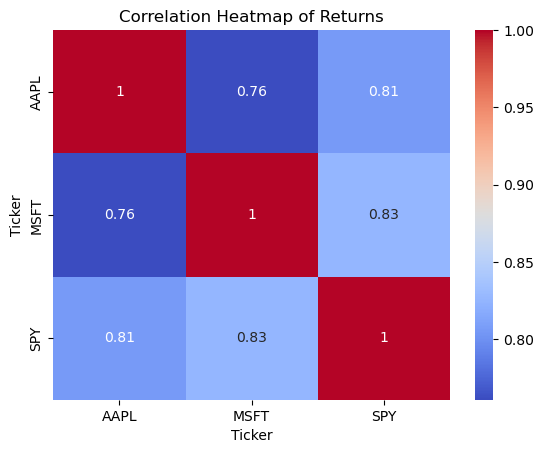

In [8]:

corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Returns")
plt.show()

These are very high correlations (all above 0.7), suggesting strong co-movement between the returns of these assets.

**Regression: AAPL ~ MSFT + SPY**

In [9]:

X = returns[["MSFT", "SPY"]]
y = returns["AAPL"]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1320.
Date:                Thu, 02 Oct 2025   Prob (F-statistic):          2.91e-309
Time:                        10:08:01   Log-Likelihood:                 3826.8
No. Observations:                1257   AIC:                            -7648.
Df Residuals:                    1254   BIC:                            -7632.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.403      0.1

**Model Fit**

R-squared = 0.678

The model explains about 67.8% of the variation in AAPL returns, which is relatively high for financial data.

F-statistic is highly significant (p < 0.001) the model overall is statistically valid.

Coefficients

MSFT coefficient = 0.3172 (p < 0.001)

SPY coefficient = 0.8536 (p < 0.001)

Both predictors are statistically significant at the 1% level, meaning each contributes information in explaining AAPL returns.

The const (intercept) is insignificant (p = 0.161), which is common in return regressions.

**Signs of Multicollinearity**

High Correlations (Heatmap Evidence): MSFT and SPY are strongly correlated (ρ ≈ 0.83). This suggests overlapping explanatory power.

Condition Number (Cond. No. = 156):

A condition number above 30 is often considered a red flag for multicollinearity.

At 156, this indicates serious multicollinearity in the regression design matrix.

Inflated Standard Errors:

Even though MSFT and SPY are significant here, their std errors (0.030 and 0.043) are larger than they would be in a low-collinearity setting.

This inflation reduces the reliability of coefficient estimates.

**Implications**

While the model overall is strong, it is difficult to disentangle the unique effect of MSFT vs. SPY on AAPL. Both are highly collinear, so their coefficients may be unstable if the sample period or dataset changes.


The regression is still useful for forecasting AAPL returns, since MSFT and SPY together capture much of the same information.However, it is not reliable for inference (e.g. answering what is the effect of MSFT returns alone on AAPL returns?).

**Variance Inflation Factor (VIF)**

In [10]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

  Variable       VIF
0    const  1.003232
1     MSFT  3.144774
2      SPY  3.144774


**Rule of Thumb:** 

VIF = 1 No correlation with other predictors.

VIF between 1–5 Moderate correlation, but usually not severe.

VIF > 10 Serious multicollinearity problem.


Both MSFT and SPY have VIF ≈ 3.14.

This indicates moderate multicollinearity, but not at a severe level (since it is below 5).

The VIF values suggest that while there is correlation, it’s not extreme enough to cause numerical instability just some inflation in standard errors.

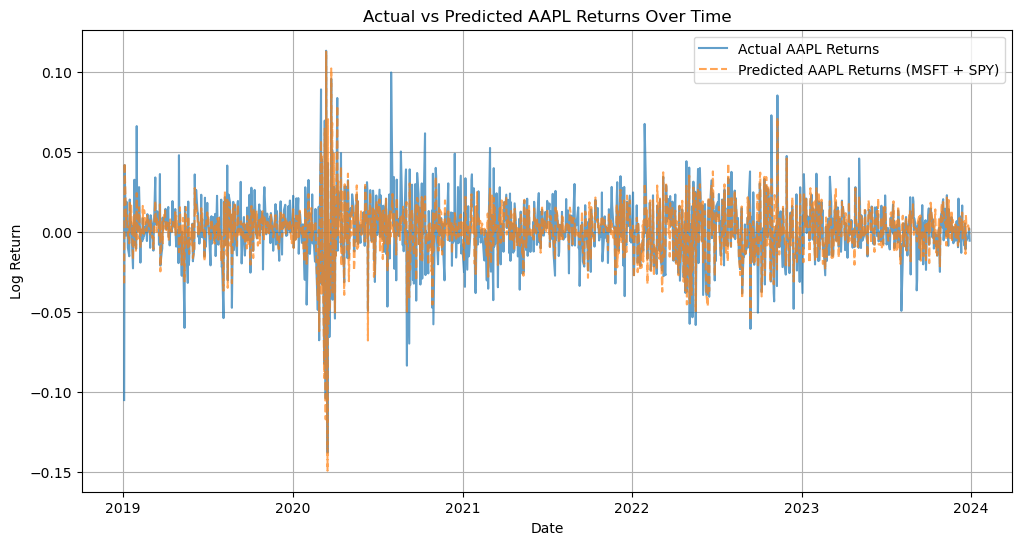

In [11]:
# --- Predicted vs Actual AAPL Returns ---
returns["AAPL_Pred"] = model.predict(X)

# --- Line Plot ---
plt.figure(figsize=(12,6))
plt.plot(returns.index, returns["AAPL"], label="Actual AAPL Returns", alpha=0.7)
plt.plot(returns.index, returns["AAPL_Pred"], label="Predicted AAPL Returns (MSFT + SPY)", alpha=0.7, linestyle="--")
plt.title("Actual vs Predicted AAPL Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.show()

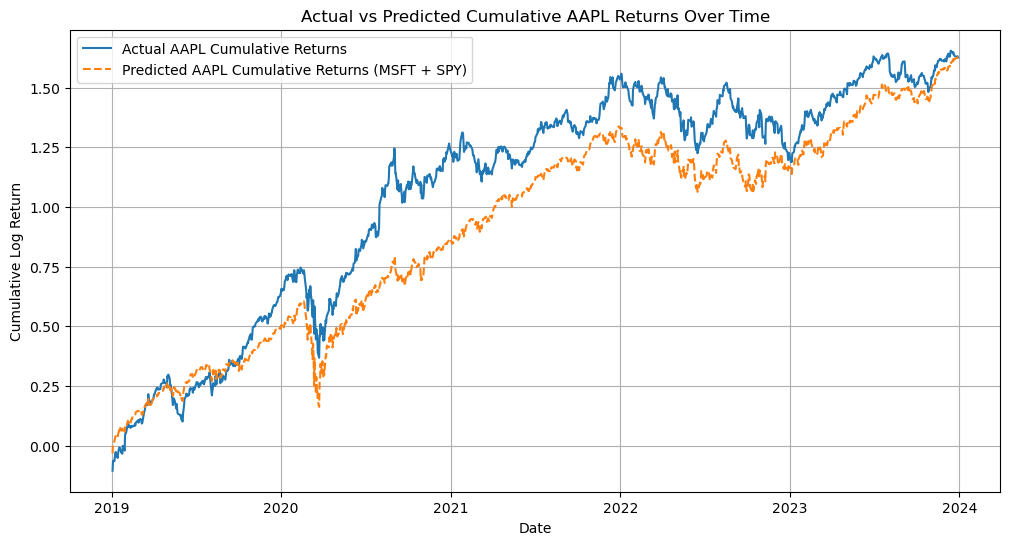

In [12]:
# --- Cumulative Returns (smoother view) ---
returns["AAPL_Cum"] = returns["AAPL"].cumsum()
returns["AAPL_Pred_Cum"] = returns["AAPL_Pred"].cumsum()

plt.figure(figsize=(12,6))
plt.plot(returns.index, returns["AAPL_Cum"], label="Actual AAPL Cumulative Returns")
plt.plot(returns.index, returns["AAPL_Pred_Cum"], label="Predicted AAPL Cumulative Returns (MSFT + SPY)", linestyle="--")
plt.title("Actual vs Predicted Cumulative AAPL Returns Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()


The cumulative returns plot demonstrates that MSFT and SPY jointly explain AAPL’s long-term movements, confirming the predictive strength of the regression. However, the high correlation between MSFT and SPY indicates multicollinearity, which complicates coefficient interpretation. This explains why the model captures overall trends but struggles to attribute effects to MSFT versus SPY individually. Thus, while multicollinearity does not severely harm prediction, it reduces reliability for inference in financial time series regressions.

## Conclusion

Taken together:

Heatmap: Strong pairwise correlations (ρ > 0.8).

OLS Regression: High R² but large condition number (156).

VIF: Moderate collinearity (≈3.1).

These results confirm that multicollinearity is present in the regression of AAPL on MSFT and SPY. Although not severe enough to invalidate the model, it complicates inference: individual coefficients should be interpreted cautiously because of overlapping explanatory power. However, for forecasting purposes, this degree of multicollinearity is unlikely to pose a major problem.